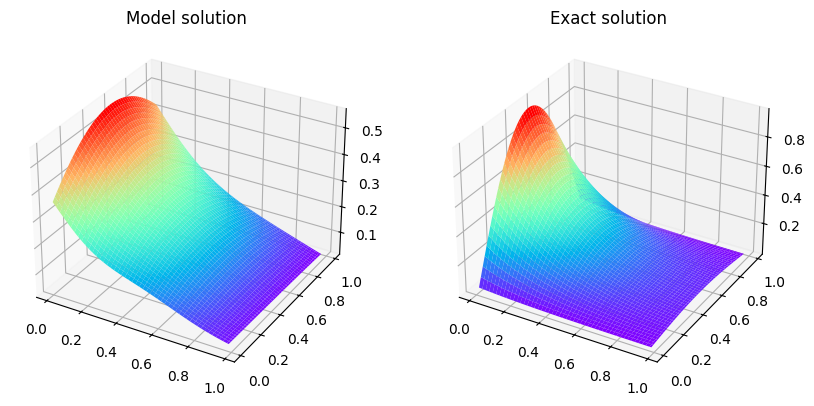

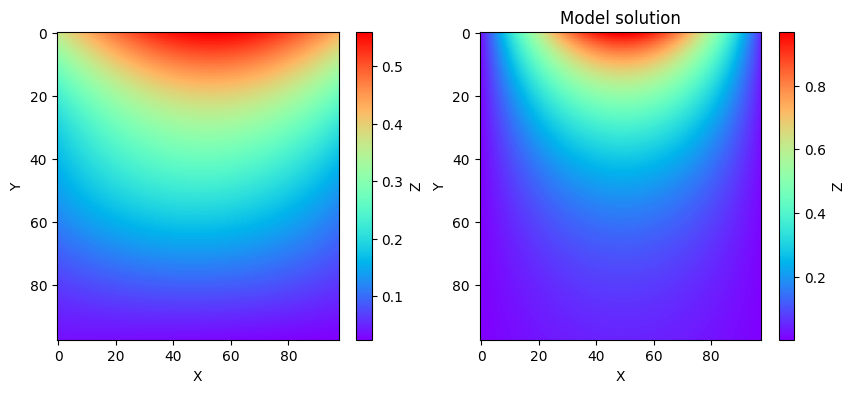

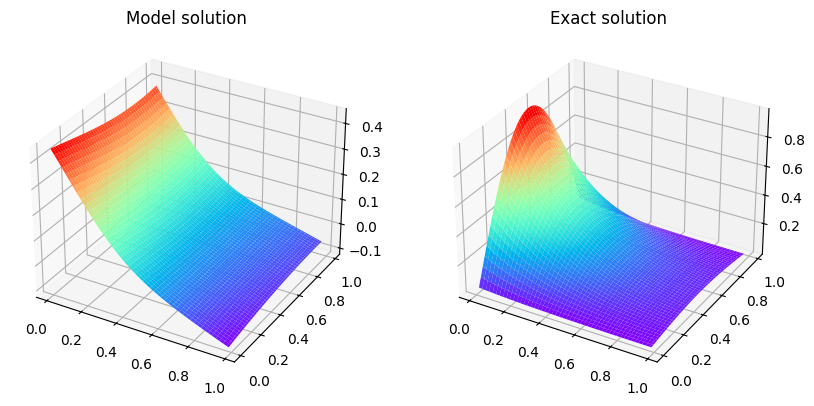

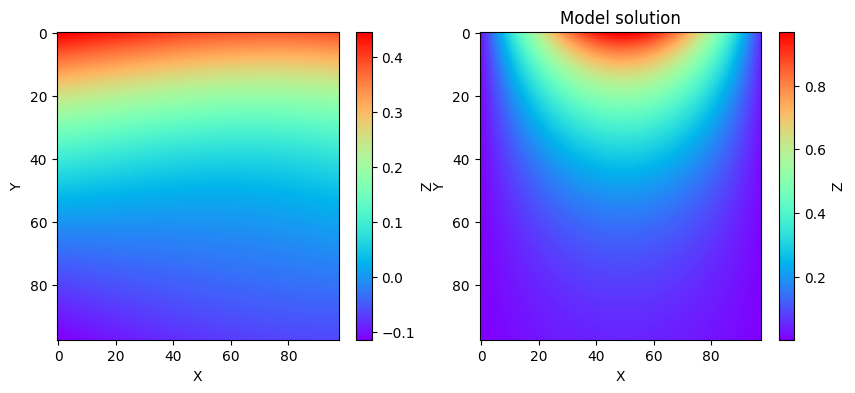

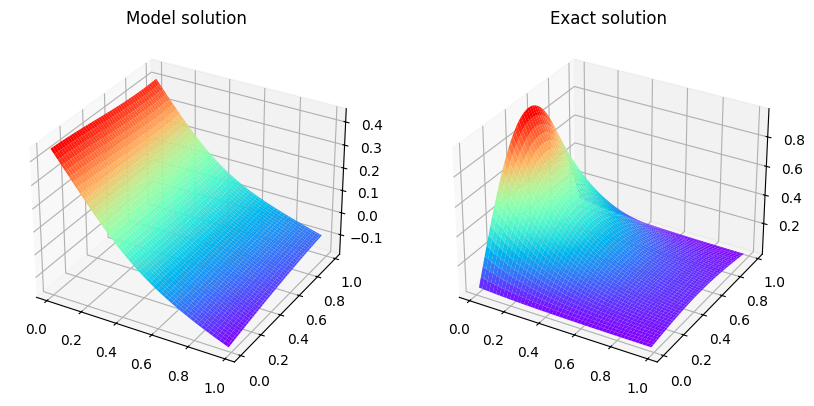

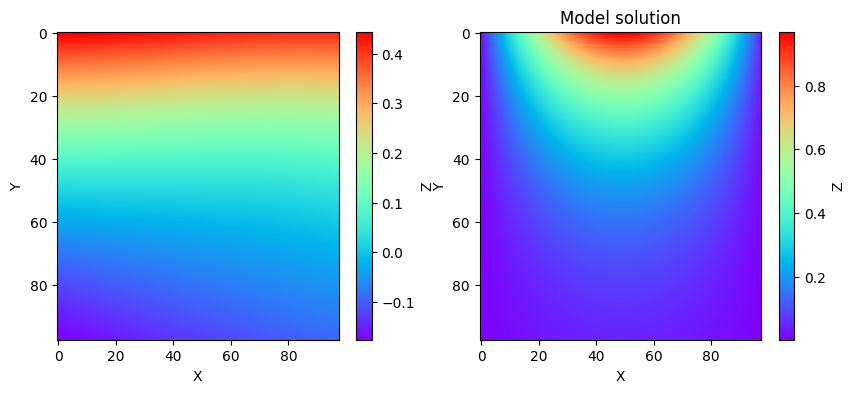

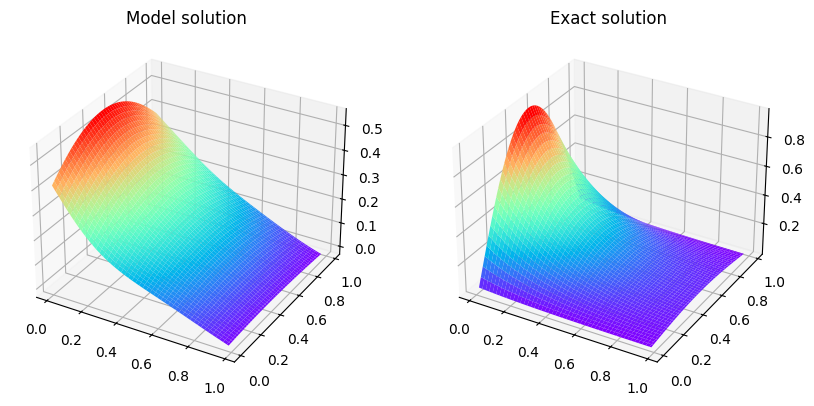

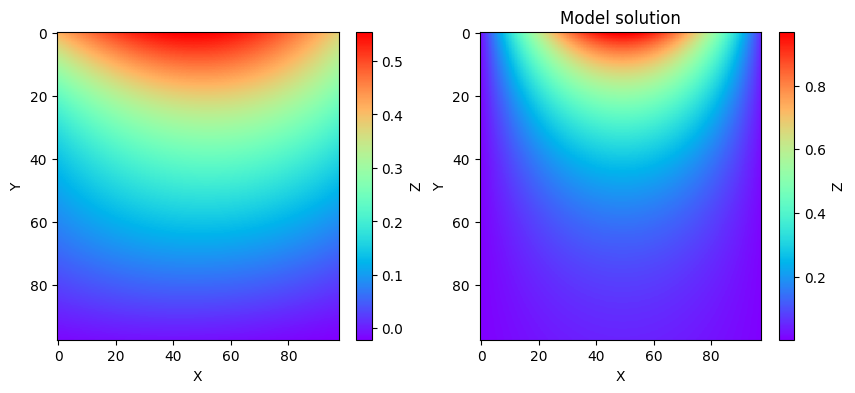

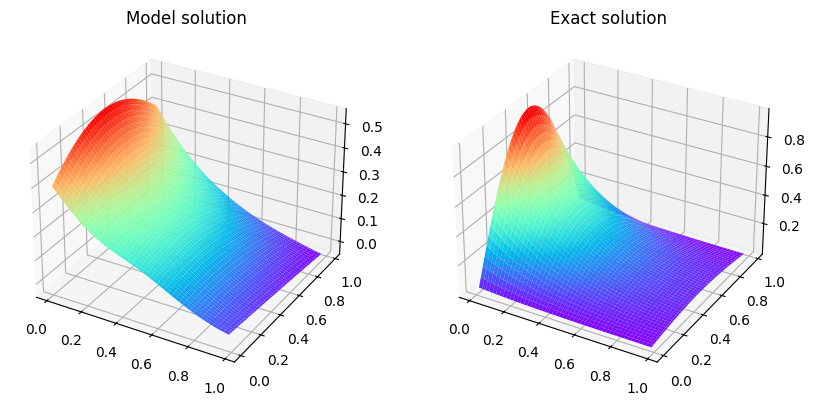

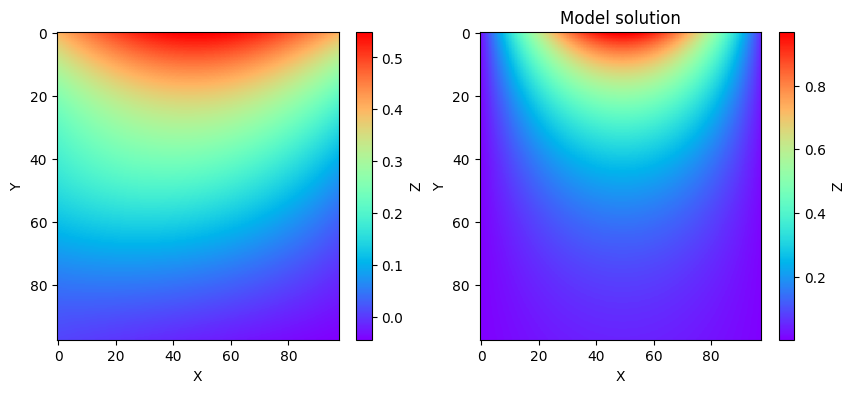

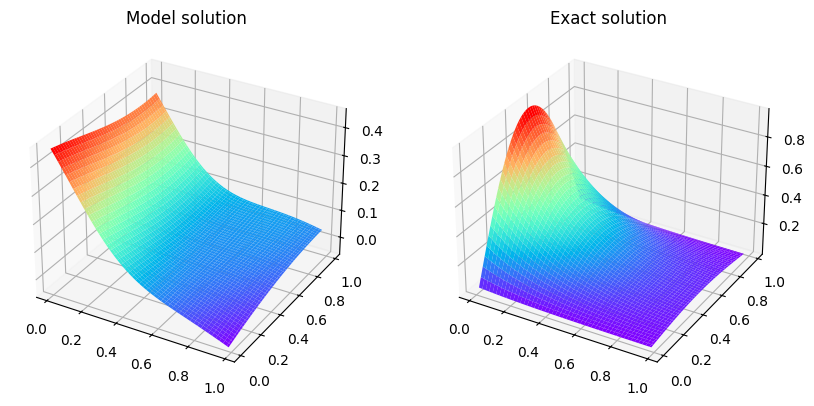

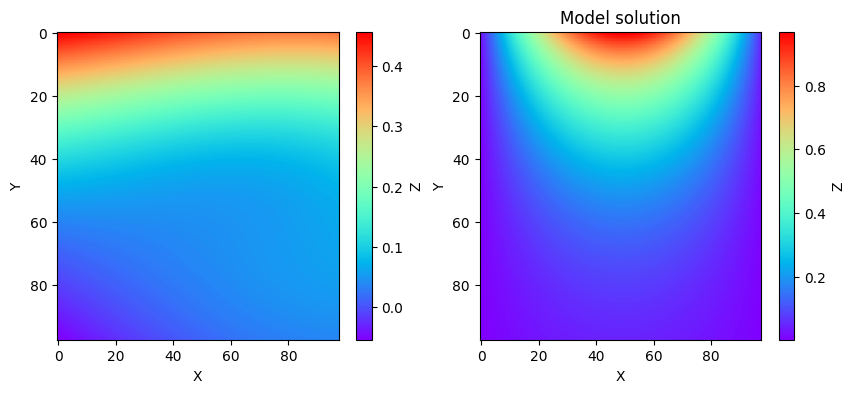

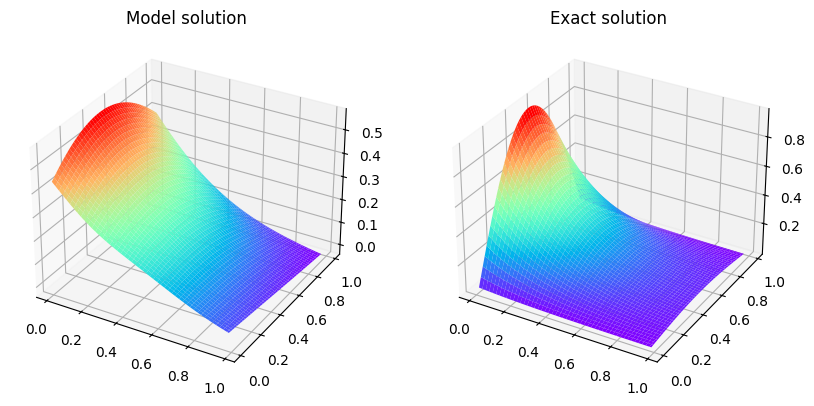

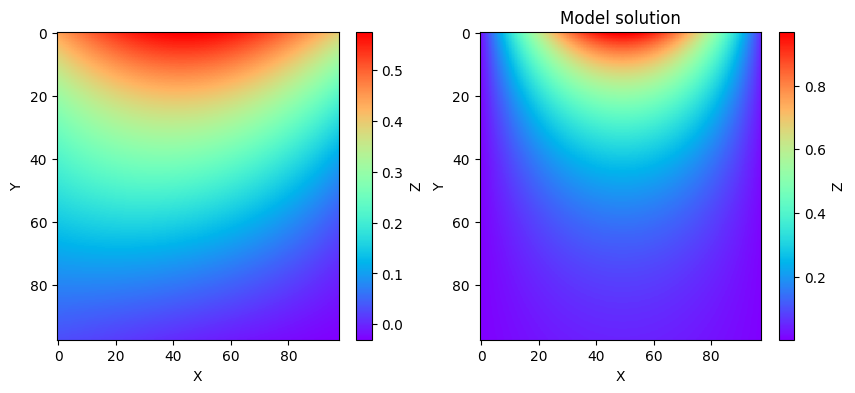

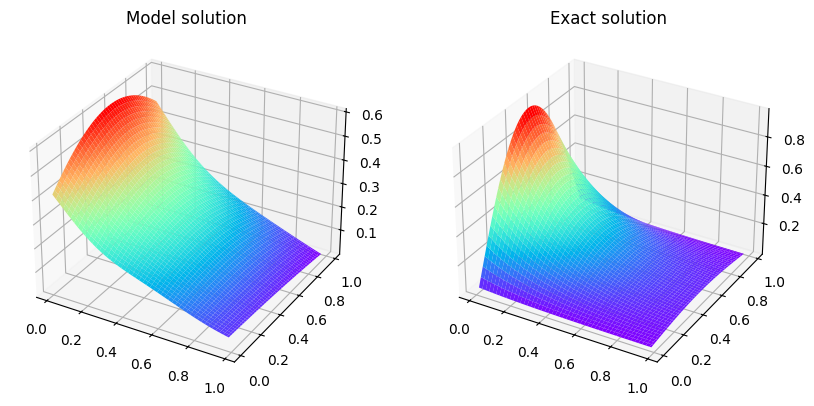

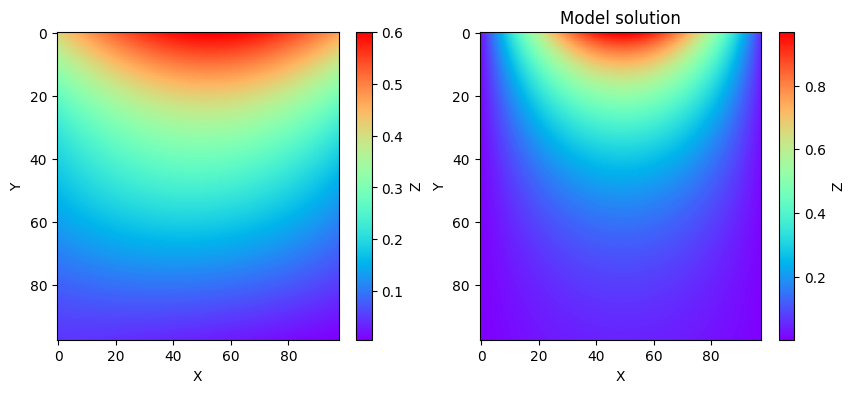

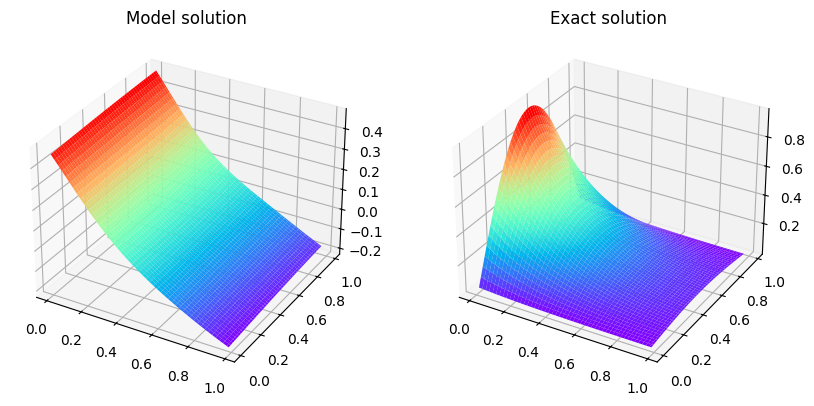

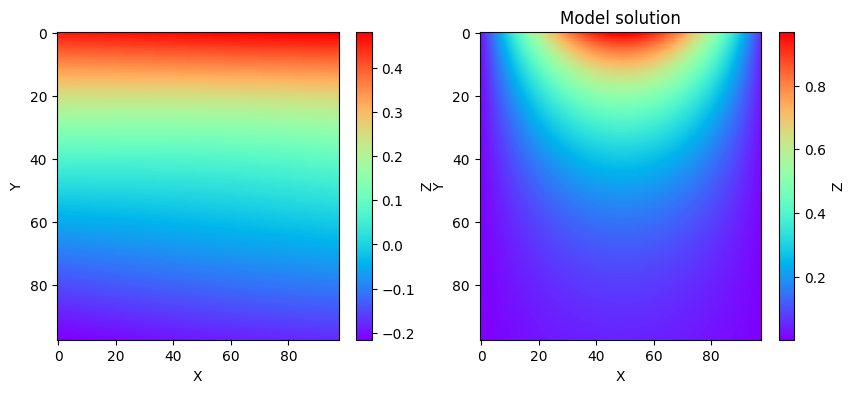

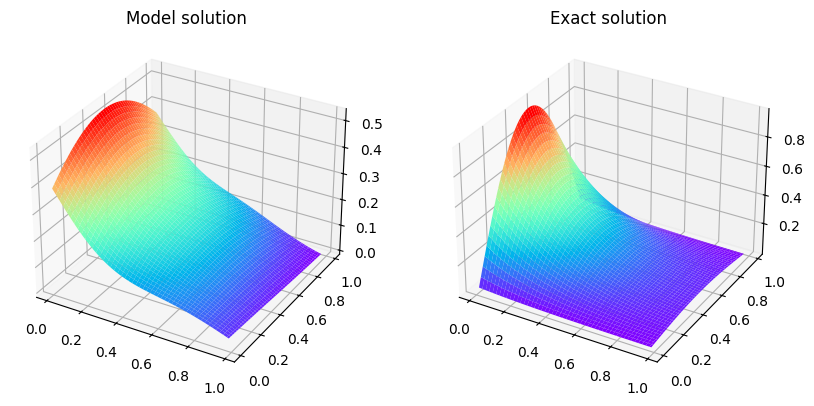

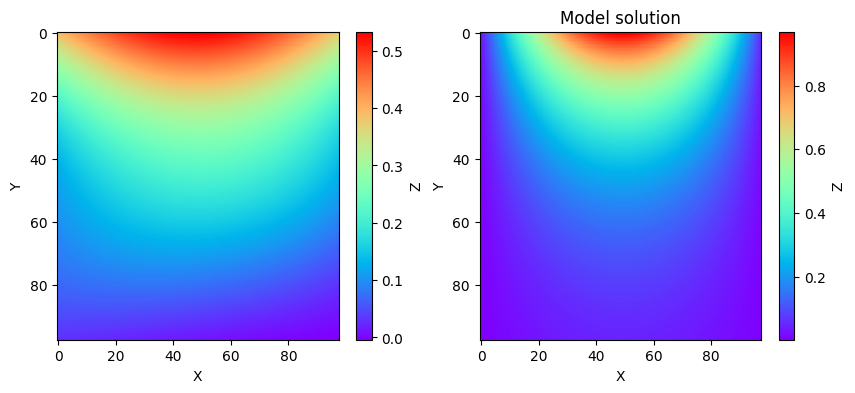

In [6]:
import torch
import qadence
import graphviz
import numpy as np

scores = []
for i in range(1,11):
    
    torch.manual_seed(i)
    
    # def calc_deriv(outputs: torch.Tensor, inputs: torch.Tensor) -> torch.Tensor:
    #     """Compute a derivative of model that learns f(x), computes df/dx using torch.autograd."""
    #     grad = torch.autograd.grad(
    #         outputs=outputs,
    #         inputs=inputs,
    #         grad_outputs = torch.ones_like(inputs),
    #         create_graph = True,
    #         retain_graph = True,
    #     )[0]
    #     return grad
    
    # Mean-squared error as the comparison criterion
    criterion = torch.nn.MSELoss()
    
    def loss_fn(model: torch.nn.Module, inputs: torch.Tensor) -> torch.Tensor:
        """Loss function encoding the problem to solve."""
        # Equation loss
        model_output = model(inputs)
        # Get the first order derivatives for both x and y
        grads = torch.autograd.grad(model_output, inputs, grad_outputs=torch.ones_like(model_output), create_graph=True, retain_graph=True)[0]
        f_m_x, f_m_y = grads[:,0], grads[:,1]
        # Get the second order derivatives for both x and y
        grads_x = torch.autograd.grad(f_m_x, inputs, grad_outputs=torch.ones_like(f_m_x), create_graph=True)[0]
        f_m_x_x = grads_x[:,0]
        grads_y = torch.autograd.grad(f_m_y, inputs, grad_outputs=torch.ones_like(f_m_y), create_graph=True)[0]
        f_m_y_y = grads_y[:,1]
        deriv_model = f_m_x_x + f_m_y_y
        deriv_exact = torch.zeros_like(deriv_model)
        pde_loss = criterion(deriv_model, deriv_exact) #MSE between derivative of models func and exact func
        # print(pde_loss)
        # Boundary losses: 
        #   f(0,y) = sin(pi*y)
        #   f(x,0) = 0
        #   f(1,y) = exp(-pi)*sin(pi*y)
        #   f(x,1) = 0
        x=torch.rand(10)
        y=torch.rand(10)
        zeros = torch.zeros(10)
        ones = torch.ones(10)
    
        all_coords = [torch.stack((zeros, y)),
                  torch.stack((x, zeros)),
                  torch.stack((ones, y)),
                  torch.stack((x, ones))]
        
        # for t in all_coords:
        #     print(t.size())
        
        bounds = [torch.sin(torch.pi*y),
                  zeros,
                  torch.exp(-torch.pi*ones)*torch.sin(torch.pi*y),
                  zeros]

        # for t in bounds:
        #     print(t.size())
        
        tot_boundary_losses = 0
        for i,(coords,boundary_exact) in enumerate(zip(all_coords,bounds)):
            boundary_model = model(coords.T)
            # print(boundary_model)
            # if i == 0:
            #     boundary_loss = 0.001*criterion(boundary_model, boundary_exact)
            # else:
            #     boundary_loss = 5*criterion(boundary_model, boundary_exact)
            boundary_loss = criterion(boundary_model, boundary_exact)
            # print(boundary_loss)
            # tot_boundary_losses += boundary_loss**2
            tot_boundary_losses += boundary_loss
        sqrt_tot_boundary_losses = torch.sqrt(tot_boundary_losses)
        
        return 0.01*pde_loss + tot_boundary_losses
    
    from qadence import feature_map, exp_fourier_feature_map, hea, chain, kron, operations, add
    from qadence import QNN, QuantumCircuit, Z, RY, RX
    from qadence.types import BasisSet, ReuploadScaling
    from qadence.draw import display
    
    n_qubits = 6
    depth = 3
    
    # Feature map
    # fm_x = feature_map(
    #     n_qubits = 3,
    #     param = "x",
    #     fm_type = BasisSet.CHEBYSHEV,
    #     reupload_scaling = ReuploadScaling.EXP,
    #     support = (0, 1, 2)
    # )
    # fm_y = feature_map(
    #     n_qubits = 3,
    #     param = "y",
    #     op = RY,
    #     fm_type = BasisSet.FOURIER,
    #     support = (3, 4, 5)
    # )

    from sympy import atan, Function
    
    fm_x = feature_map(
    n_qubits = 6,
    param = "x",
    fm_type = atan,
    reupload_scaling = ReuploadScaling.EXP,
    )

    fm_y = feature_map(
        n_qubits = 6,
        param = "y",
        op = RY,
        fm_type = BasisSet.FOURIER,
    )
    
    display(fm_x,fm_y)

    ''' start new part '''

    from qadence import Strategy

    ansatz = hea(
        n_qubits,
        depth=depth,
        strategy=Strategy.SDAQC
    )
    
    from qadence.constructors import identity_initialized_ansatz
    from qadence.draw import display
    from qadence import hamiltonian_factory, Interaction, N, Register, hea
    
    register = Register.honeycomb_lattice(1, 1)
    
    entangler = hamiltonian_factory(
        register,
        interaction=Interaction.NN,
        detuning=N,
        interaction_strength="e",
        detuning_strength="n"
    )
    
    # Build a fully parameterized Digital-Analog HEA:
    n_qubits = register.n_qubits
    depth = 2
    
    
    # Ansatz
    ansatz = hea(
        n_qubits=register.n_qubits,
        depth=depth,
        operations=[RX, RY, RX],
        entangler=entangler,
        strategy=Strategy.SDAQC
    )
    ''' end new part '''
    # # Ansatz
    # ansatz = hea(n_qubits = n_qubits, depth = 6)
    
    # Observable
    # observable = (add(Z(i) for i in range(3)) * add(Z(i) for i in range(3,6)))
    observable = Z(0) + 0.5*operations.I(1)
    
    circuit = QuantumCircuit(n_qubits, chain(fm_x, fm_y, ansatz))
    model = QNN(circuit = circuit, observable = observable, inputs = ["x", "y"])
    
    n_epochs = 200
    n_points = 70
    
    xmin = 0.01
    xmax = 0.99


    optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)
        
    for epoch in range(n_epochs):
        optimizer.zero_grad()
    
        # Training data. A grid of points between 0 and 1 for both dimensions. We unsqueeze essentially making each batch have a single x value.
        xy_train = (xmin + (xmax-xmin)*torch.rand(n_points, 2, requires_grad = True))
    
        loss = loss_fn(inputs = xy_train, model = model)
        # print(loss)
        loss.backward()
        optimizer.step()
        

    import matplotlib.pyplot as plt
        
    def f_exact(xy: torch.Tensor) -> torch.Tensor:
        x, y = xy[:,0], xy[:,1]
        exp_x = torch.exp(-torch.pi * x)
        sin_y = torch.sin(torch.pi * y)
        return (exp_x * sin_y)
        
    # Grid of 2d points 
    x_test = torch.arange(xmin, xmax, step = 0.01)
    y_test = torch.arange(xmin, xmax, step = 0.01)
    meshx, meshy = torch.meshgrid(x_test,y_test)
    xy_test = torch.stack((meshx.flatten(), meshy.flatten()), dim=1)
    
    result_exact = f_exact(xy_test).flatten()
    result_model = model(xy_test).flatten().detach()
    
    ## SCORE
    
    n_points_1d = 100 # Use a grid of 100x100
    # Create a length = 10.000 tensor of the (x, y) coordinates between 0 and 1
    domain_1d = torch.linspace(0, 1.0, steps = n_points_1d)
    domain = torch.cartesian_prod(domain_1d, domain_1d)
    # Getting the exact solution and the DQC solution
    exact_sol = f_exact(domain).reshape(n_points_1d, n_points_1d).T
    dqc_sol = model(domain).reshape(n_points_1d, n_points_1d).T.detach()
    # Mean Squared Error as the comparison criterion
    criterion = torch.nn.MSELoss()
    # Final score, the lower the better
    score = criterion(dqc_sol, exact_sol)
    scores.append(score)
    # score.abs().item()
    
    ## VISUALIZATION
    
    reshaped_model = result_model.reshape((len(x_test),len(x_test))).detach().numpy()
    reshaped_exact = result_exact.reshape((len(x_test),len(x_test))).detach().numpy()
    
    # Plot the exact and the model solutions side by side in 3D
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')
    X, Y = torch.meshgrid(x_test, y_test)
    ax1.plot_surface(X, Y, reshaped_model, cmap='rainbow')
    ax1.set_title('Model solution')
    ax2.plot_surface(X, Y, reshaped_exact, cmap='rainbow')
    ax2.set_title('Exact solution')
    plt.show()

    # Plot the heatmap with color scale
    fig2 = plt.figure(figsize=(10, 4))
    ax3 = fig2.add_subplot(121)
    ax4 = fig2.add_subplot(122)
    heatmap = ax3.imshow(reshaped_model, cmap='rainbow', aspect='auto')
    plt.colorbar(heatmap, label='Z')  # Add color bar with label
    ax4.set_title('Model solution')
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    heatmap = ax4.imshow(reshaped_exact, cmap='rainbow', aspect='auto')
    plt.colorbar(heatmap, label='Z')  # Add color bar with label
    ax4.set_title('Model solution')
    ax4.set_xlabel('X')
    ax4.set_ylabel('Y')
    plt.show()

In [13]:
print(scores)
print(np.mean(scores))

[tensor(0.0115), tensor(0.0308), tensor(0.0310), tensor(0.0108), tensor(0.0114), tensor(0.0261), tensor(0.0115), tensor(0.0121), tensor(0.0345), tensor(0.0113)]
0.019093451185748855


In [3]:
# # 1D Evaluation Code
# n_points_1d = 100 # Use a grid of 100x100
# # Create a length = 10.000 tensor of the (x, y) coordinates between 0 and 1
# domain_1d = torch.linspace(0, 1.0, steps = n_points_1d)
# domain = torch.tensor(list(domain_1d))
# # The exact solution for the Laplace equation
# def exact_ode(domain: torch.Tensor):
#     x = domain
#     return x**4 + (1/3)*x**3 - x**2 - 0.5*x + 10

# # Getting the exact solution and the DQC solution
# exact_sol = exact_ode(domain).T #.reshape(n_points_1d, n_points_1d).T
# dqc_sol = model(domain).T.detach()
# # Mean Squared Error as the comparison criterion
# criterion = torch.nn.MSELoss()
# # Final score, the lower the better
# score = criterion(dqc_sol, exact_sol)
# print(score)


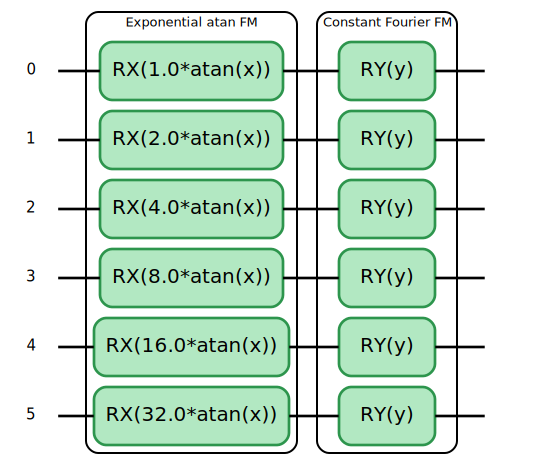

In [4]:
torch.manual_seed(1)

# def calc_deriv(outputs: torch.Tensor, inputs: torch.Tensor) -> torch.Tensor:
#     """Compute a derivative of model that learns f(x), computes df/dx using torch.autograd."""
#     grad = torch.autograd.grad(
#         outputs=outputs,
#         inputs=inputs,
#         grad_outputs = torch.ones_like(inputs),
#         create_graph = True,
#         retain_graph = True,
#     )[0]
#     return grad

# Mean-squared error as the comparison criterion
criterion = torch.nn.MSELoss()

def loss_fn(model: torch.nn.Module, inputs: torch.Tensor) -> torch.Tensor:
    """Loss function encoding the problem to solve."""
    # Equation loss
    model_output = model(inputs)
    # Get the first order derivatives for both x and y
    grads = torch.autograd.grad(model_output, inputs, grad_outputs=torch.ones_like(model_output), create_graph=True, retain_graph=True)[0]
    f_m_x, f_m_y = grads[:,0], grads[:,1]
    
    # Get the second order derivatives for both x and y
    grads_x = torch.autograd.grad(f_m_x, inputs, grad_outputs=torch.ones_like(f_m_x), create_graph=True)[0]
    f_m_x_x = grads_x[:,0]
    grads_y = torch.autograd.grad(f_m_y, inputs, grad_outputs=torch.ones_like(f_m_y), create_graph=True)[0]
    f_m_y_y = grads_y[:,1]
    deriv_model = f_m_x_x + f_m_y_y
    deriv_exact = torch.zeros_like(deriv_model)
    pde_loss = criterion(deriv_model, deriv_exact) #MSE between derivative of models func and exact func
    # print(pde_loss)
    # Boundary losses: 
    #   f(0,y) = sin(pi*y)
    #   f(x,0) = 0
    #   f(1,y) = exp(-pi)*sin(pi*y)
    #   f(x,1) = 0
    x=torch.rand(10)
    y=torch.rand(10)
    zeros = torch.zeros(10)
    ones = torch.ones(10)

    all_coords = [torch.stack((zeros, y)),
              torch.stack((x, zeros)),
              torch.stack((ones, y)),
              torch.stack((x, ones))]
    
    # for t in all_coords:
    #     print(t.size())
    
    bounds = [torch.sin(torch.pi*y),
              zeros,
              torch.exp(-torch.pi*ones)*torch.sin(torch.pi*y),
              zeros]

    # for t in bounds:
    #     print(t.size())
    
    tot_boundary_losses = 0
    for i,(coords,boundary_exact) in enumerate(zip(all_coords,bounds)):
        boundary_model = model(coords.T)
        # print(boundary_model)
        # if i == 0:
        #     boundary_loss = 0.001*criterion(boundary_model, boundary_exact)
        # else:
        #     boundary_loss = 5*criterion(boundary_model, boundary_exact)
        boundary_loss = criterion(boundary_model, boundary_exact)
        # print(boundary_loss)
        # tot_boundary_losses += boundary_loss**2
        tot_boundary_losses += boundary_loss
    sqrt_tot_boundary_losses = torch.sqrt(tot_boundary_losses)
    
    return 0.01*pde_loss + tot_boundary_losses

from qadence import feature_map, exp_fourier_feature_map, hea, chain, kron, operations, add
from qadence import QNN, QuantumCircuit, Z, RY, RX
from qadence.types import BasisSet, ReuploadScaling
from qadence.draw import display

n_qubits = 6
depth = 3

# Feature map
# fm_x = feature_map(
#     n_qubits = 3,
#     param = "x",
#     fm_type = BasisSet.CHEBYSHEV,
#     reupload_scaling = ReuploadScaling.EXP,
#     support = (0, 1, 2)
# )
# fm_y = feature_map(
#     n_qubits = 3,
#     param = "y",
#     op = RY,
#     fm_type = BasisSet.FOURIER,
#     support = (3, 4, 5)
# )

from sympy import atan, Function

fm_x = feature_map(
n_qubits = 6,
param = "x",
fm_type = atan,
reupload_scaling = ReuploadScaling.EXP,
)

fm_y = feature_map(
    n_qubits = 6,
    param = "y",
    op = RY,
    fm_type = BasisSet.FOURIER,
)
display(chain(fm_x, fm_y))